In [4]:
%load_ext autoreload
%autoreload 2

In [11]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

In [12]:
from lrp import lrp_engine, checkpoint_hook

In [13]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
for layer_module in model.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [15]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states : torch.Tensor = model(inputs, requires_grad=True)[0] # [1, sequence_length, 768]

In [16]:
checkpoint_vals, in_adj_list, out_adj_list, visited1 = lrp_engine(hidden_states)

took 4.118374824523926 seconds


In [18]:
from add_backward_promise import AddBackwardPromise
visited = sorted(list(visited1), key=lambda x: x._sequence_nr())
visited_map = { str(node) : node for node in visited }
promises = AddBackwardPromise.all_promises

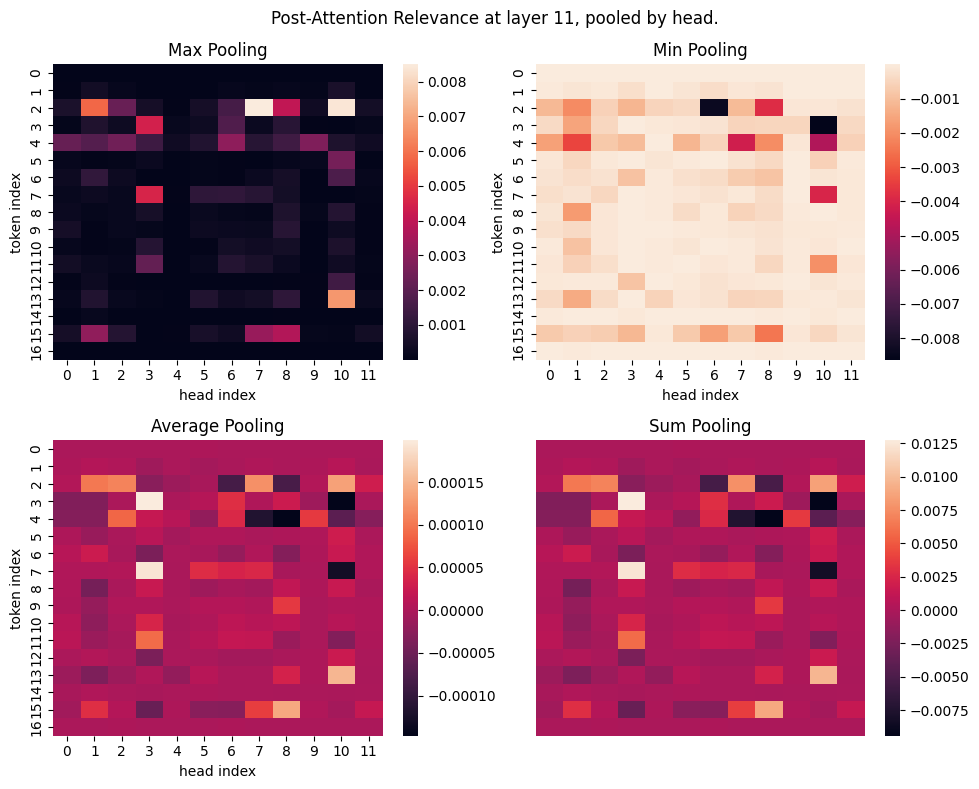

In [20]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 11

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(checkpoint_vals[layer_ind], 0))
    sns.heatmap(checkpoint_output.view((17, 12)), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head.")
fig.tight_layout()

plt.show()

In [11]:
# For debugging relevance paths

# import networkx as nx
# import matplotlib.pyplot as plt

# node_to_ind = { node : i for (i, node) in enumerate(nodes) }
# def create_graph(nodes, in_adj_list, weights, alpha = 0.5):    
#     G = nx.DiGraph()
#     G.add_nodes_from(range(len(nodes)))

#     print(node_to_ind[start], node_to_ind[end]) # Global vars, set somewhere

#     for node, in_nodes in list(in_adj_list.items()):
#         if node not in nodes:
#             continue
#         for in_node, in_weight in zip(in_nodes, input_tracker[node]):
#             if in_node not in nodes:
#                 continue
#             if isinstance(in_weight, AddBackwardPromise):
#                 if in_weight.complete:
#                     in_weight = in_weight.rin.sum()
#                 else:
#                     continue
#             elif isinstance(in_weight, torch.Tensor):
#                 in_weight = in_weight.sum()
#             G.add_edge(node_to_ind[in_node], node_to_ind[node], weight=float(in_weight))
#     return G

# def display_graph(G):
#     pos = nx.circular_layout(G)  
#     weight_labels = nx.get_edge_attributes(G, 'weight')
#     plt.figure(figsize=(50,50))
#     nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=100)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)  
#     plt.show()

# G = create_graph(nodes, in_adj_list, input_tracker)

# print([ x for x in dir(nx) if x.endswith("layout") ])
# display_graph(G)
# print(nx.get_edge_attributes(G, 'weight'))


In [12]:
# Check that promises maintain conservation property
complete = list(filter(lambda p: p.complete, promises))
for p in complete:
    rout = p.promise["rout"].sum()
    rin = p.promise["rins"][0].sum() + p.promise["rins"][1].sum()
    if (rout - rin) / rout > 0.00001:
        print(rout, rin)
        

In [13]:
# Checking conservation holds across the entire propagation
# The frontier includes:
# a) true leaf nodes (no children)
# b) nodes which received inputs but were never traversed due to computation ending early

frontier = [ node 
            for node, out_nodes in list(out_adj_list.items())
            if len(out_nodes) == 0
           ]

frontier += [ node for node in stack if input_tracker[node] ]

frontier = list(set(frontier))

In [14]:
# Tally the total relevance at the frontier
total_frontier_in = 0.0
for node in frontier:
    total_in = 0.0
    for input_ in input_tracker[node]:
        if isinstance(input_, AddBackwardPromise):
            if input_.complete:
                total_in += input_.rin.sum()
            else:
                continue
        elif isinstance(input_, torch.Tensor):
            total_in += input_.sum()
    total_frontier_in += total_in
print(total_frontier_in)

tensor(17.0376)
